<a href="https://colab.research.google.com/github/robinhester/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((45042, 41), (14358, 41), (14358, 40))

In [0]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas_profiling
import numpy as np
import plotly.express as px
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    #Make a copy
    X = X.copy()
    
    #replace zeros in latitude
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()

    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)

    #get top ten subvillage and replace others with other
    top10=X['subvillage'].value_counts()[:5].index
    X.loc[~X['subvillage'].isin(top10),'subvillage']== 'Other'

    #get top 5 funders and replace others with other
    top5=X['funder'].value_counts()[:5].index
    X.loc[~X['funder'].isin(top5),'funder']=='Other'

    #top 10 extraction type, set the rest to other
    top10ext=X['extraction_type'].value_counts()[:5].index
    X.loc[~X['extraction_type'].isin(top10ext),'extraction_type']=='Other'

    #get top 5 installers and replace others with other
    top5install=X['installer'].value_counts()[:5].index
    X.loc[~X['installer'].isin(top5install),'installer']=='Other'


    #get top regions, replace others with other
    top_region=X['region'].value_counts()[:5].index
    X.loc[~X['region'].isin(top_region),'region']=='Other'

    #convert recorded year to datetime and get the year
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X['date_recorded_year']=X['date_recorded'].dt.year
    X = X.drop(columns='date_recorded')

    #get the years between date recorded and construction of the well
    X['years_between']=X['date_recorded_year']-X['construction_year']
    X['years_MISSING'] = X['years_between'].isnull()

    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
train=train.drop(columns='id')
val=val.drop(columns='id')

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 20].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape

((45042, 37), (45042,), (14358, 37), (14358,), (14358, 37))

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(random_state=25, n_jobs=-1, max_depth=20, 
                           n_estimators=323, verbose=90, max_features=7,
                           min_samples_split=3)
)

pipeline.fit(x_train, y_train)
print('Training Accuracy', pipeline.score(x_train, y_train))
print ('Validation Accuracy', pipeline.score(x_val, y_val))


# Predict on test
y_pred = pipeline.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
building tree 1 of 323
building tree 2 of 323
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 3 of 323
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
building tree 4 of 323
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
building tree 5 of 323
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
building tree 6 of 323
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
building tree 7 of 323
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
building tree 8 of 323
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
building tree 9 of 323
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
building tree 10 of 323
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
building tree 11 of 323
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
building tree 12 of 323
[Parallel(n_jobs=-1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

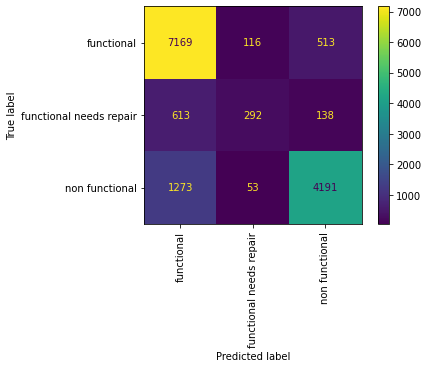

In [0]:
import sklearn
sklearn.__version__

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, x_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [0]:
accuracy_score(y_val, y_pred)

0.4695640061289873

In [0]:
from sklearn.metrics import classification_report
print (classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.54      0.62      0.58      7798
functional needs repair       0.08      0.03      0.05      1043
         non functional       0.37      0.33      0.35      5517

               accuracy                           0.47     14358
              macro avg       0.33      0.33      0.33     14358
           weighted avg       0.44      0.47      0.45     14358



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

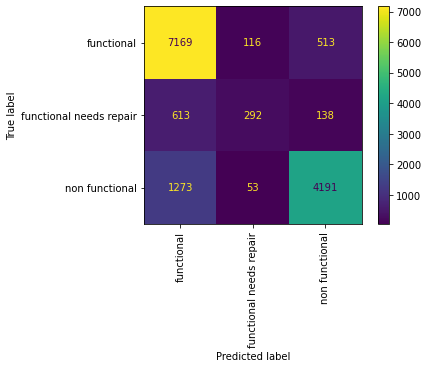

In [0]:
cm = plot_confusion_matrix(pipeline, x_val, y_val, values_format='.0f', xticks_rotation='vertical')
cm

# precision = true_positives / (true_positives + positives)
# recall = true_positives / (true_positives + false_negatives)



In [0]:
print (classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.54      0.62      0.58      7798
functional needs repair       0.08      0.03      0.05      1043
         non functional       0.37      0.33      0.35      5517

               accuracy                           0.47     14358
              macro avg       0.33      0.33      0.33     14358
           weighted avg       0.44      0.47      0.45     14358



In [0]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [0]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [0]:
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
building tree 1 of 323
building tree 2 of 323
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
building tree 3 of 323
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
building tree 4 of 323
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
building tree 5 of 323
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
building tree 6 of 323
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
building tree 7 of 323
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
building tree 8 of 323
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
building tree 9 of 323
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
building tree 10 of 323
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
building tree 11 of 323
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
building tree 12 of 323
[Parallel(n_jobs=-1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

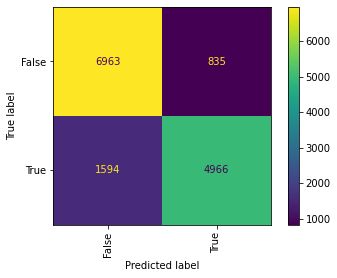

In [0]:
plot_confusion_matrix(pipeline, x_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [0]:
pipeline.predict_proba(x_val)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

array([[4.34498848e-04, 9.99565501e-01],
       [2.21229630e-01, 7.78770370e-01],
       [9.90193752e-01, 9.80624784e-03],
       ...,
       [7.33483406e-01, 2.66516594e-01],
       [4.56331210e-01, 5.43668790e-01],
       [9.73462975e-01, 2.65370246e-02]])

In [0]:
pipeline.predict(x_val)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

array([ True,  True, False, ..., False,  True, False])

In [0]:

#Predicted probabilites for the positive class
pipeline.predict_proba(x_val)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

array([0.9995655 , 0.77877037, 0.00980625, ..., 0.26651659, 0.54366879,
       0.02653702])

In [0]:
threshold = 0.925
sum(pipeline.predict_proba(x_val)[:, 1] > threshold)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

2632

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.0s
[Para

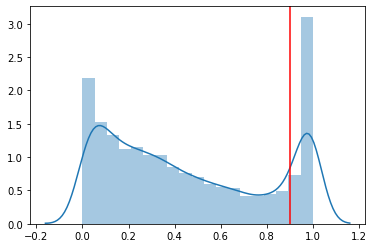

In [0]:
import seaborn as sns

y_pred_proba = pipeline.predict_proba(x_val)[:, 1]
ax = sns.distplot(y_pred_proba)
threshold = 0.9
ax.axvline(threshold, color='red')

In [0]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

         # accuracy 0.83
         # accuracy 0.70

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [0]:
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.037348,1.000000
2,0.000000,0.037652,0.999993
3,0.000000,0.041463,0.999989
4,0.000000,0.042226,0.999986
...,...,...,...
4142,0.997435,1.000000,0.001088
4143,0.997692,1.000000,0.001066
4144,0.998076,1.000000,0.001022
4145,0.999872,1.000000,0.001021


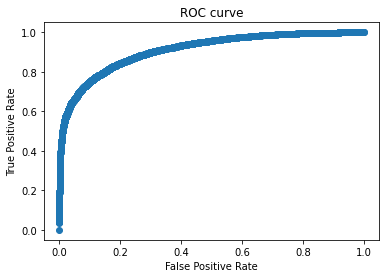

In [0]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [0]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9101662734816306